In [1]:
from pathlib import Path
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import datetime
import calendar
import numpy as np
import os
import glob
from openpyxl import load_workbook
%matplotlib inline

abnormal_time_arr = np.array(['17:35', '17:55', '18:35', '18:55', '19:35', '19:55'])

# 2883 개 하루 15분 단위 데이터 93개 93 * 31 = 2883
# 각 월 데이터 개수 출력
def Month_RawCount(_year,_month,_df) :
    startTime = '2021-0'+str(_month)+'-01 00:00:00'
    endTime = '2021-0'+str(_month)+'-'+str(calendar.monthrange(_year,_month)[1])+' 23:00:00'
    startTime = datetime.datetime.strptime(startTime, "%Y-%m-%d %H:%M:%S")
    endTime = datetime.datetime.strptime(endTime, "%Y-%m-%d %H:%M:%S")
    result = _df[(_df['날짜'] >= startTime) & (_df['날짜'] <= endTime)]
    print(str(i)+"월 데이터 : "+str(len(result)))
    
   
# 월df을 받아 하루 단위로 분리 후 엑셀로 저장    
def SplitDayExcel(_year,_month,_MonthlyDf,_path):
    lastDay = calendar.monthrange(_year,_month)
    for i in range(1,lastDay[1]+1):
        if(i > 10):
            startDay = str(_year)+'-0'+str(_month)+'-'+str(i)+' 00:00:00'
            endDay = str(_year)+'-0'+str(_month)+'-'+str(i)+' 23:00:00'
        else:
            startDay = str(_year)+'-'+str(_month)+'-'+str(i)+' 00:00:00'
            endDay = str(_year)+'-'+str(_month)+'-'+str(i)+' 23:00:00'

        startDay = datetime.datetime.strptime(startDay,"%Y-%m-%d %H:%M:%S")
        endDay = datetime.datetime.strptime(endDay,"%Y-%m-%d %H:%M:%S")
        OneDay_df = _MonthlyDf[(_MonthlyDf['날짜'] >= startDay) & (_MonthlyDf['날짜'] <= endDay)].copy()

        if not (os.path.isdir(_path)):
            os.mkdir(_path)

        if not OneDay_df.empty:
            if(_month < 10):
                if(i < 10):
                    filePath = _path+'/'+str(_year)+'-0'+str(_month)+'-0'+str(i)+'.xlsx'
                else:
                    filePath = _path+'/'+str(_year)+'-0'+str(_month)+'-'+str(i)+'.xlsx'
            else:
                filePath = _path+'/'+str(_year)+'-'+str(_month)+'-'+str(i)+'.xlsx'
            OneDay_df.to_excel(filePath, index = False)
            wb = load_workbook(filePath)
            ws = wb.active
            ws.column_dimensions['D'].width = 24
            wb.save(filePath)

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib import parse 

# API를 이용해 국경일,대체 공휴일 포함 공휴일 DF 추출

# _apiKey :
# _url :
# 가져올 정보 명
# _year : 국경일 찾을 년도
def getHoliday(_apiKey,_url,_operation,_year):
    api_key_decode = parse.unquote(_apiKey)

    url_holiday = _url + _operation
    params = {
        "ServiceKey":api_key_decode,
        "solYear":_year,
        "numOfRows": 100
    }
    
    Day_list= ['Mon','Tues','Wednes','Thurs','Fri','Satur','Sun']
    
    response = requests.get(url_holiday, params = params)
    xml = BeautifulSoup(response.text, "lxml")
    items = xml.find('items')
    item_list = []

    for item in items:
        dt = datetime.datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d')
        item_dict = {
            "이름" : item.find("datename").text.strip(),
            "날짜" : dt,
            "요일" : Day_list[dt.weekday()]+'day'
        }
        item_list.append(item_dict)
    return pd.DataFrame(item_list)

# 국경일 평일 df 추출
def getHolidayWeekDay(_NationalHolidayDf):
    _HolidayWeekDayDf = _NationalHolidayDf[_NationalHolidayDf['날짜'].dt.dayofweek < 5]
    return _HolidayWeekDayDf

# 국경일 주말 df 추출
def getHolidayWeekEnd(_NationalHolidayDf):
    _HolidayWeekEndDf = _NationalHolidayDf[_NationalHolidayDf['날짜'].dt.dayofweek > 4]
    return _HolidayWeekEndDf

In [4]:
_apiKey = ""
url = "	http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/"
operation = "getRestDeInfo"

NationalHolidayDf = getHoliday(_apiKey,url,operation,2021)
NationalHolidayDf

,이름,날짜,요일
0,1월1일,2021-01-01,Friday
1,설날,2021-02-11,Thursday
2,설날,2021-02-12,Friday
3,설날,2021-02-13,Saturday
4,삼일절,2021-03-01,Monday
5,어린이날,2021-05-05,Wednesday
6,부처님오신날,2021-05-19,Wednesday
7,현충일,2021-06-06,Sunday
8,광복절,2021-08-15,Sunday
9,대체공휴일,2021-08-16,Monday


In [5]:
# 데이터 전처리 메소드

# folder 안의 vds 데이터 합치기
def ExcelAppend(_folder) :
    rawData_dir = Path(_folder)
    excel_files = rawData_dir.glob('*월.xlsx')

    total_df = pd.DataFrame()

    for excel_file in excel_files:
        df = pd.read_excel(excel_file)
        total_df = total_df.append(df, ignore_index=True)
    return total_df

# 데이터프레임 각 행 문자열 없애기
def PreprocessingTotalDf(_total_df) :
    _total_df['교통량'] = _total_df['교통량'].str.extract('(\d+)')
    _total_df['교통량'] = pd.to_numeric(_total_df['교통량'])
    _total_df['속도'] = _total_df['속도'].str.replace('km/h',"")
    _total_df['날짜'] = pd.to_datetime(_total_df['날짜'],format="%Y-%m-%d %H:%M:%S")
    return _total_df

# DF 날짜 속성을 '날짜','시간'으로 분리 후 df 반환
def Separation_Date_Time(_df):
    _df['날짜'] = _df['날짜'].dt.strftime('%Y-%m-%d %H:%M')
    _df['시간'] = _df.날짜.str.split(' ').str[1]
    _df['날짜'] = _df.날짜.str.split(' ').str[0]
    _df['교통량'] = pd.to_numeric(_df['교통량'])
    _df['날짜'] = pd.to_datetime(_df['날짜'],format='%Y-%m-%d')
    return _df

# 시간대별 교통량 DF 추출 후 _SumOrStat : 0 = 15분 단위별 교통량 합계 DF 반환, 1 = 15분 단위별 교통량 평균 DF 반환
def Extraction_DF_Traffic_SumOrStat(_df,_SumOrStat):
    month_df = _df[['시간','교통량']]
    if(_SumOrStat == 0):
        month_sum = month_df.groupby('시간').sum()
        return month_sum
    elif(_SumOrStat == 1):
        month_stat = month_df.groupby('시간').mean()
        month_stat['교통량'] = round(month_stat['교통량'],2)
        return month_stat
    else:
        exception = "_SumOrStat : 0 -> Sum , 1 -> Stat"
        return exception
    
# 상관분석할 데이터 프레임 생성    
def MakeCorrelation_df(_timeKey,val1_key,val2_key,_time,_val1,_val2):
    Correlation_df = pd.DataFrame({_timeKey:_time,
                                    val1_key : _val1,
                                    val2_key : _val2 })
    return Correlation_df

In [6]:
# 특정 월, 일 주말, 평일 데이터 추출 DF 반환

# 월별 데이터 추출 DF 반환
def ExtractionMonthlyData(_findYear,_findMonth,_totalDf):
    _df = _totalDf.copy()
    lastDay = calendar.monthrange(_findYear,_findMonth)
    if(_findMonth < 10):
        startTime = str(_findYear)+'-0'+str(_findMonth)+'-01 00:00:00'
        endTime = str(_findYear)+'-0'+str(_findMonth)+'-'+str(lastDay[1])+' 23:00:00'
    else :
        startTime = str(_findYear)+'-'+str(_findMonth)+'-01 00:00:00'
        endTime = str(_findYear)+'-'+str(_findMonth)+'-'+str(lastDay[1])+' 23:00:00'
        
    startTime = datetime.datetime.strptime(startTime, "%Y-%m-%d %H:%M:%S")
    endTime = datetime.datetime.strptime(endTime, "%Y-%m-%d %H:%M:%S")
    result = _df[(_df['날짜'] >= startTime) & (_df['날짜'] <= endTime)].copy()
    return result
    
# 특정일 데이터 추출 DF 반환    
def ExtractionOneDayData(_findYear, _findMonth, _findDay, _totalDf):
    if(_findMonth < 10):
        if(_findDay < 10):
            startTime = str(_findYear)+'-0'+str(_findMonth)+'-0'+str(_findDay)+ ' 00:00:00'
            endTime = str(_findYear)+'-0'+str(_findMonth)+'-0'+str(_findDay)+ ' 23:00:00'
        else:
            startTime = str(_findYear)+'-0'+str(_findMonth)+'-'+str(_findDay)+ ' 00:00:00'
            endTime = str(_findYear)+'-0'+str(_findMonth)+'-'+str(_findDay)+ ' 23:00:00'
    else:
        if(_findDay < 10):
            startTime = str(_findYear)+'-'+str(_findMonth)+'-0'+str(_findDay)+ ' 00:00:00'
            endTime = str(_findYear)+'-'+str(_findMonth)+'-0'+str(_findDay)+ ' 23:00:00'
        else:
            startTime = str(_findYear)+'-'+str(_findMonth)+'-'+str(_findDay)+ ' 00:00:00'
            endTime = str(_findYear)+'-'+str(_findMonth)+'-'+str(_findDay)+ ' 23:00:00'
        
    startTime = datetime.datetime.strptime(startTime, "%Y-%m-%d %H:%M:%S")
    endTime = datetime.datetime.strptime(endTime, "%Y-%m-%d %H:%M:%S")
    result = _totalDf[(_totalDf['날짜'] >= startTime) & (_totalDf['날짜'] <= endTime)].copy()
    return result

# 월별 특정 요일 데이터 추출 DF 반환(아래 방향으로 계속 이어짐)
# _day : 0~6 , 월~일
def Extraction_Monthly_SelectedDayData(_year,_month,_findDay,_folderPath):
    if not (os.path.isdir(_folderPath)):
        print("폴더 존재하지 않음")
        return

    file_list = os.listdir(_folderPath + str(_year) + '_' + str(_month)+'월/')
    file_name = []
    find_df = pd.DataFrame()
    for files in file_list:
        fileName = files.split('.')[0]
        file_name.append(fileName)

    for files in file_name:
        _dateStr = datetime.datetime.strptime(files,'%Y-%m-%d')
        if(_dateStr.weekday()==_findDay):
            df = pd.read_excel(_folderPath + str(_year) + '_' + str(_month)+'월/'+files+'.xlsx')
            find_df = find_df.append(df,ignore_index=True)
    return find_df

# 특정 월 특정 요일 DF 반환(결측치 처리 방식 : 결측값 = (앞 시간 교통량+뒷 시간 교통량)/2 )
# 특정 요일들 교통량들이 행 방향으로 이뤄진 df 반환
def Extraction_SelectedMonth_SelectedDaysData(_year,_month,_findDay,_folderPath):
    if not (os.path.isdir(_folderPath)):
        print("폴더 존재하지 않음")
        return
    
    file_list = os.listdir(_folderPath+ str(_year) + '_' + str(_month)+ '월/')
    file_name = []
    for files in file_list:
        fileName = files.split('.')[0]
        file_name.append(fileName)
    
    count = 0
    merge_df = pd.DataFrame()
    SelectedFileName = ['시간']
    
    for files in file_name:
        _dateStr = datetime.datetime.strptime(files,'%Y-%m-%d')
        if(_dateStr.weekday()==_findDay):
            df = pd.read_excel(_folderPath + str(_year) + '_' + str(_month) + '월/' + files + '.xlsx')
            SelectedFileName.append(files)
            df = Separation_Date_Time(df)
            df = df[['시간','교통량']]
            if(count == 0):
                merge_df = df
                count = 1
            else:
                merge_df = pd.merge(merge_df,df,how='outer',on='시간')
    merge_df.columns = SelectedFileName
    merge_df = merge_df.sort_values(by=['시간'],ascending=True)
    merge_df = merge_df.reset_index(drop=True)

#     중간에 하나의 결측 값이 있을때 해결, 결측치 해결 여러 문제가 있음. (데이터가 통째로 없을때, 결측치 기준으로 위아래 데이터가 없을때)
#     for columns in merge_df.columns:
#         if not(columns == '시간'):
#             nullIndex = merge_df.loc[merge_df[columns].isna()].index
#             if not((len(nullIndex) == 0) & (nullIndex == 0)):
#                 _val = (merge_df.loc[nullIndex[0]-1].values[1] + merge_df.loc[nullIndex[0]+1].values[1])/2
#                 merge_df.at[nullIndex[0],columns]= _val
    return merge_df

# 시작 월 끝 월 사이에서 특정 요일 데이터 추출 DF 반환
# 전체 월 DF도 반환
def Extraction_AllMonthly_SelectedDayData(_findDay,_totalDf):
    _resultDf = _totalDf[_totalDf['날짜'].dt.dayofweek ==_findDay]
    return _resultDf

# 특정 월 중에서 평일 DF 반환
def Extraction_SelectedMonth_WeekDayData(_year,_month,_totalDf):
    _monthDf = ExtractionMonthlyData(_year,_month,_totalDf)
    _weekDayDf = _monthDf[_monthDf['날짜'].dt.dayofweek < 5]
    return _weekDayDf
    
# 특정 월 중에서 주말 DF 반환    
def Extraction_SelectedMonth_WeekEndData(_year,_month,_totalDf):
    _monthDf = ExtractionMonthlyData(_year,_month,_totalDf)
    _weekEndDf = _monthDf[_monthDf['날짜'].dt.dayofweek > 4]
    return _weekEndDf
    
# 전체 월 중에서 평일 DF 반환    
def Extraction_SelectedAllMonth_WeekDayData(_totalDf):
    _weekDayDf = _totalDf[_totalDf['날짜'].dt.dayofweek < 5]    
    return _weekDayDf
    
# 전체 월 중에서 주말 DF 반환    
def Extraction_SelectedAllMonth_WeekEndData(_totalDf):
    _weekEndDf = _totalDf[_totalDf['날짜'].dt.dayofweek > 4]
    return _weekEndDf

# 전체 월 중에서 국경일 제외한 DF 반환
# _weekDayDf = 국경일 포함한 평일 DF
# _nationalDayDf = 공휴일 DF
def Extraction_ExceptNationalDay_WeekDayData(_totalDf, _nationalDayDf):
    _All_df = Separation_Date_Time(_totalDf)
    _NationalHolidayWeekDayDf = getHolidayWeekDay(_nationalDayDf).copy()
    
    _NationalHolidayWeekDayDf['날짜'] = _NationalHolidayWeekDayDf['날짜'].dt.strftime('%Y-%m-%d')
    _All_df['날짜'] = _All_df['날짜'].dt.strftime('%Y-%m-%d')
    
    for _date in _NationalHolidayWeekDayDf['날짜']:
        _arr = _All_df[_All_df['날짜'] == _date].index
        if(len(_arr) != 0):
            _All_df = _All_df.drop(_arr)
    return _All_df

# 전체 월 중에서 국경일인데 평일인 DF 반환
def Extraction_NationalDay_WeekDayData(_totalDf, _nationalDayDf):
    _All_df = Separation_Date_Time(_totalDf)
    _NationalHolidayWeekDayDf = getHolidayWeekDay(_nationalDayDf).copy()
    
    _NationalHolidayWeekDayDf['날짜'] = _NationalHolidayWeekDayDf['날짜'].dt.strftime('%Y-%m-%d')
    _All_df['날짜'] = _All_df['날짜'].dt.strftime('%Y-%m-%d')
    
    _NationalTrafficDf = pd.DataFrame()

    for _date in _NationalHolidayWeekDayDf['날짜']:
        _arr = _All_df[_All_df['날짜'] == _date].index
        if(len(_arr) != 0):
            _NationalTrafficDf = _NationalTrafficDf.append(_All_df.iloc[_arr], ignore_index=True)  
    _NationalTrafficDf['날짜'] = pd.to_datetime(_NationalTrafficDf['날짜'],format='%Y-%m-%d')
    return _NationalTrafficDf

#특정 월별 평일 데이터 DF추출(파일에서 바로 읽어옴)
#국경일 제외
def Extraction_Monthly_WeekDayData(_year,_month,_day,_folderPath,_nationalHolidayDf):
    if not(os.path.isdir(_folderPath)):
        print("폴더 존재하지 않음")
        return
    
    _folder = _folderPath + str(_year) + '_' + str(_month)+ '월/'
    file_list = os.listdir(_folder)
    _nationalDaylist = _nationalHolidayDf['날짜'].dt.strftime('%Y-%m-%d').copy()
    
    if(_month < 10):
        if(_day < 10):
            file_name = str(_year)+'-0'+str(_month)+'-0'+str(_day)+'.xlsx'
        else:
            file_name = str(_year)+'-0'+str(_month)+'-'+str(_day)+'.xlsx'
    else:
        if(_day < 10):
            file_name = str(_year)+'-'+str(_month)+'-0'+str(_day)+'.xlsx'
        else:
            file_name = str(_year)+'-'+str(_month)+'-'+str(_day)+'.xlsx'
            
    if file_name in file_list:
        Full_fileName = file_name.split('.')[0]
        if not Full_fileName in _nationalDaylist.values:
            _weekday = datetime.datetime.strptime(Full_fileName,'%Y-%m-%d')
            if(_weekday.weekday() < 5):
                _oneDayDf = pd.read_excel(_folder+file_name)
                return _oneDayDf
    else:
        return

# 국경일 포함 주말 DF반환
def Extraction_Monthly_WeekEndData(_year,_month,_day,_folderPath,_nationalHolidayDf):
    if not(os.path.isdir(_folderPath)):
        print("폴더 존재하지 않음")
        return
    
    _folder = _folderPath + str(_year) + '_' + str(_month)+ '월/'
    file_list = os.listdir(_folder)
    _nationalDaylist = _nationalHolidayDf['날짜'].dt.strftime('%Y-%m-%d').copy()
    
    if(_month < 10):
        if(_day < 10):
            file_name = str(_year)+'-0'+str(_month)+'-0'+str(_day)+'.xlsx'
        else:
            file_name = str(_year)+'-0'+str(_month)+'-'+str(_day)+'.xlsx'
    else:
        if(_day < 10):
            file_name = str(_year)+'-'+str(_month)+'-0'+str(_day)+'.xlsx'
        else:
            file_name = str(_year)+'-'+str(_month)+'-'+str(_day)+'.xlsx'
            
    if file_name in file_list:
        Full_fileName = file_name.split('.')[0]
        _weekEnd = datetime.datetime.strptime(Full_fileName,'%Y-%m-%d')
        if Full_fileName in _nationalDaylist.values:
            _oneDayDf = pd.read_excel(_folder+file_name)
            return _oneDayDf
        elif(_weekEnd.weekday() > 4):
            _oneDayDf = pd.read_excel(_folder+file_name)
            return _oneDayDf
        else:
            return
    else:
        return

In [7]:
# 데이터 크기, 결측치 확인 관련함수

# 결측값 개수 확인
def CheckDF_IsNull(_df):
    print(_df.isnull().sum())

# DF 타입 확인
def CheckDF_Types(_df):
    print(_df.dtypes)
    
# DF shape확인
def CheckDF_shape(_df):
    print(_df.shape)

# 상관 분석시 shape을 맞추기 위함
# index가 적은 df에서 index가 많은 df가 갖고 있는 index를 추출해 index가 많은 df에서 차집합 index를 제외시킨다. 
def Preprocessing_IsNull(_BigDf,_SmallDf):
    if (len(_BigDf) > len(_SmallDf)):
        _arr = np.setdiff1d(_BigDf.index,_SmallDf.index)
    else:
        print("앞의 파라미터에 인덱스가 더 많은 DF를 입력")
    if(len(_arr) != 0):
        _Result = _BigDf['교통량'].drop(_arr)
        return _Result
    else:
        return _BigDf

In [8]:
# 그래프 관련 함수

# _figsize = (w,h)
# _df = 데이터 프레임
# _plotType = 0 : plot , else: scatter
# _SumOrStat = 0 : Sum , 1 : Average
# _monthName = 몇월 데이터인지
def ChartPlot(_figsize,_df,_plotType,_SumOrStat,_monthName):
    plt.rc('font', family='NanumGothic')
    plt.figure(figsize=_figsize)
    
    if(_plotType == 0) :
        plt.plot(_df['교통량'])
    else :
        plt.scatter(_df['교통량'].index,_df.values)
    plt.xticks(rotation=45)
    
    if(_SumOrStat == 0) :
        plt.title(_monthName+"Month Traffic volume Sum")
    else :
        plt.title(_monthName+"Month Traffic volume Average")
    plt.xlabel("time")
    plt.ylabel("traffic volume")
    plt.grid(True)
    plt.show()
    #plt.savefig('./내덕칠거리/사진/test.png')

# 월별 요일별 그래프 그리기
def DrawMonthlyDayGraph(_year,_month,_df,_figsize):
    df = Separation_Date_Time(_df)
    stat_Month_Df = ExtractionMonthlyData(_year,_month,df)
    Day_list = ['Mon','Tues','Wednes','Thurs','Fri','Satur','Sun']
    fig = plt.figure(figsize=_figsize)
    ax = fig.add_subplot()

    for i in range(0,7):
        Day_df = stat_Month_Df[stat_Month_Df['날짜'].dt.dayofweek == i]
        Day_df = Extraction_DF_Traffic_SumOrStat(Day_df,1)
        ax.plot(Day_df['교통량'],label=Day_list[i])
    ax.legend()
    plt.xticks(rotation=45)
    plt.title(str(_month)+'Month Day Traffic Average Graph')
    plt.xlabel("time")
    plt.ylabel("traffic volume")
    plt.grid(True)
    plt.show()    
    
# 월별 요일별 그래프 그리기
def DrawAllMonthDayGraph(_year,_totalDf,_figsize):
    df = Separation_Date_Time(_totalDf)
    Day_list = ['Mon','Tues','Wednes','Thurs','Fri','Satur','Sun']
    fig = plt.figure(figsize=_figsize)
    ax = fig.add_subplot()

    for i in range(0,7):
        Day_df = df[df['날짜'].dt.dayofweek == i]
        Day_df = Extraction_DF_Traffic_SumOrStat(Day_df,1)
        ax.plot(Day_df['교통량'],label=Day_list[i])
    ax.legend()
    plt.xticks(rotation=45)
    plt.title('All Month Day Traffic Average Graph')
    plt.xlabel("time")
    plt.ylabel("traffic volume")
    plt.grid(True)
    plt.show()  
    
# 상관 분석 그래프 그리기
def DrawCorrelation(X,Y,_figsize) :
    plt.figure(figsize=_figsize)
    plt.scatter(X,Y,alpha=0.5)
    plt.show()
    
# 특정일 , 해당월의 교통량 평균 비교 그래프
def Compare_OneDay_Month_TrafficAverage(_year,_month,_day,_totalDf):
    df = Separation_Date_Time(_totalDf)
    
    stat_OneDay_Df = ExtractionOneDayData(_year, _month, _day,df)
    stat_OneDay_Df = Extraction_DF_Traffic_SumOrStat(stat_OneDay_Df,1)

    stat_Month_Df = ExtractionMonthlyData(_year, _month,df)
    stat_Month_Df = Extraction_DF_Traffic_SumOrStat(stat_Month_Df,1)
    
    _arr = np.setdiff1d(stat_Month_Df['교통량'].index,stat_OneDay_Df['교통량'].index)
    if(len(_arr) != 0):
        stat_Month_Df = stat_Month_Df['교통량'].drop(_arr) 
    
    fig = plt.figure(figsize = (20,5))
    ax = fig.add_subplot()
    
    ax.plot(stat_OneDay_Df.index,stat_OneDay_Df.values,label= pd.Timestamp(str(_year)+'-'+str(_month)+'-'+str(_day)).day_name())
    ax.plot(stat_Month_Df.index,stat_Month_Df.values,label= str(_month)+'Month')
    ax.legend()
    plt.xticks(rotation=45)
    plt.title('Compare Selected Day , Month Traffic Average Graph')
    plt.xlabel('time')
    plt.ylabel('traffic volume')
    plt.grid(True)
    plt.show()
    
# 특정월, 전체월의 교통량 평균 비교 그래프
def Compare_OneMonth_AllMonth_TrafficAverage(_year,_month,_totalDf):
    df = Separation_Date_Time(_totalDf)

    stat_OneMonth_Df = ExtractionMonthlyData(_year,_month,df)
    stat_OneMonth_Df = Extraction_DF_Traffic_SumOrStat(stat_OneMonth_Df,1)

    stat_AllMonth_Df = Extraction_DF_Traffic_SumOrStat(df,1)

    _arr = np.setdiff1d(stat_AllMonth_Df['교통량'].index,stat_OneMonth_Df['교통량'].index)
    if(len(_arr) != 0):
        stat_AllMonth_Df = stat_AllMonth_Df['교통량'].drop(_arr)

    fig = plt.figure(figsize = (20,5))
    ax = fig.add_subplot()

    ax.plot(stat_OneMonth_Df.index,stat_OneMonth_Df.values,label= str(_year)+'-'+str(_month))
    ax.plot(stat_AllMonth_Df.index,stat_AllMonth_Df.values,label= 'All Month')
    ax.legend()
    plt.xticks(rotation=45)
    plt.title('Compare Selected Month , AllMonth Traffic Average Graph')
    plt.xlabel('time')
    plt.ylabel('traffic volume')
    plt.grid(True)
    plt.show()

# 사진 저장
def SaveGraph(_path,_name):
    plt.savefig(_path+'/'+_name)
    
# 특정 월 특정 요일 하루 당 교통량 비교 그래프
def Draw_SelectedMonth_SelectedDays_Traffic(_year, _month, _findDay, _folderPath, _figsize):
    _df = Extraction_SelectedMonth_SelectedDaysData(_year,_month,_findDay,_folderPath)
    
    Day_list= ['Mon','Tues','Wednes','Thurs','Fri','Satur','Sun']
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot()
    
    for colIndex in range(1,len(_df.columns)):
        ax.plot(_df[_df.columns[0]],_df[_df.columns[colIndex]],label=_df.columns[colIndex])
    
    ax.legend()
    plt.xticks(rotation=45)
    plt.title(str(_month)+'month by '+Day_list[_findDay]+'day Traffic')
    plt.xlabel("time")
    plt.ylabel("traffic volume")
    plt.grid(True)
    plt.show()
    
# 평균선 진하게 해야함.
# 동그라미 작게 그리기
# 국경일 제외
# 평일 그래프 그리기
def DrawMonthlyAverage_AllWeekDay(_totalDf,_year,_month,_folderPath,_nationalHolidayDf):
    Month_WeekDaydf = Extraction_SelectedMonth_WeekDayData(_year, _month, _totalDf)
    Month_WeekDaydf = Extraction_ExceptNationalDay_WeekDayData(Month_WeekDaydf,_nationalHolidayDf)
    Month_stat = Extraction_DF_Traffic_SumOrStat(Month_WeekDaydf,1)
    
    fig = plt.figure(figsize=(25,6))
    ax = fig.add_subplot()
    ax.plot(Month_stat['교통량'],linewidth=5)
    
    for i in range(1,32):
        df = Extraction_Monthly_WeekDayData(_year,_month,i,'./상당사거리/',_nationalHolidayDf)
    
        if df is not None:
            df = Separation_Date_Time(df)
            #print('데이터개수: '+str(len(df))+'개 '+str(i)+'일')
            ax.scatter(df['시간'],df['교통량'],alpha=0.5,s=10,label=i)
            ax.legend()
    plt.xticks(rotation=45)
    plt.title(str(_month)+'Month Average And WeekDay Traffic Average')
    plt.xlabel('time')
    plt.ylabel('traffic volume')
    plt.grid(True)
    #plt.show()
    plt.savefig(_folderPath+'사진/평일/'+str(_month)+'월_평일_교통량.png')
    
# 국경일 포함
# 주말 그래프 그리기
def DrawMonthlyAverage_AllWeekEnd(_totalDf,_year,_month,_folderPath,_nationalHolidayDf):
    AllMonth_WeekEndDf = Extraction_SelectedMonth_WeekEndData(_year, _month, _totalDf)
    AllMonth_WeekEndDf = Separation_Date_Time(AllMonth_WeekEndDf)
    
    NationalWeekDayDf = Extraction_NationalDay_WeekDayData(_totalDf,_nationalHolidayDf)
    NationalWeekDayDf = ExtractionMonthlyData(_year,_month,NationalWeekDayDf)
    
    AllMonth_WeekEndDf = AllMonth_WeekEndDf.append(NationalWeekDayDf,ignore_index=True)
    AllMonth_WeekEndDf = AllMonth_WeekEndDf.sort_values(by=['날짜'],ascending=True)
    AllMonth_WeekEndDf = AllMonth_WeekEndDf.reset_index(drop=True)
    
    Month_stat = Extraction_DF_Traffic_SumOrStat(AllMonth_WeekEndDf,1)
    
    fig = plt.figure(figsize=(25,6))
    ax = fig.add_subplot()
    ax.plot(Month_stat['교통량'],linewidth=5)
    
    for i in range(1,32):
        df = Extraction_Monthly_WeekEndData(_year,_month,i,'./상당사거리/',_nationalHolidayDf)
    
        if df is not None:
            df = Separation_Date_Time(df)
            #print('데이터개수: '+str(len(df))+'개 '+str(i)+'일')
            ax.scatter(df['시간'],df['교통량'],alpha=0.5,s=10,label=i)
            ax.legend()
    plt.xticks(rotation=45)
    plt.title(str(_month)+'Month Average And WeekEnd Traffic Average')
    plt.xlabel('time')
    plt.ylabel('traffic volume')
    plt.grid(True)
    #plt.show()
    plt.savefig(_folderPath+'사진/공휴일/'+str(_month)+'월_공휴일_교통량.png')

In [9]:
total_df = ExcelAppend('./상당사거리/')
total_df = PreprocessingTotalDf(total_df)
# 결측값 확인
#total_df.isnull().sum()
#total_df.dtypes
total_df

,이름,교통량,속도,날짜,지체시간(초)
0,상당사거리,161,25.9,2021-04-15 17:15:00,0.0
1,상당사거리,74,29.6,2021-04-15 17:30:00,0.0
2,상당사거리,349,27.6,2021-04-15 17:45:00,0.0
3,상당사거리,406,25.4,2021-04-15 18:00:00,0.0
4,상당사거리,244,28.1,2021-04-15 18:15:00,0.0
...,...,...,...,...,...
9061,상당사거리,2988,19.9,2021-08-26 16:45:00,36.1
9062,상당사거리,3176,20.5,2021-08-26 17:00:00,35.8
9063,상당사거리,3280,19.7,2021-08-26 17:15:00,37.8
9064,상당사거리,3400,21.1,2021-08-26 17:30:00,35.6


In [10]:
# for i in range(4,9):
#     SplitDayExcel(2021,i,total_df,'./상당사거리/2021_'+str(i)+'월/')

In [11]:
for i in range (4,9) :
    Month_RawCount(2021,i,total_df)

4월 데이터 : 1339
5월 데이터 : 2513
6월 데이터 : 2602
7월 데이터 : 443
8월 데이터 : 2169


In [12]:
month_sum = ExtractionMonthlyData(2021,5,total_df)
month_sum = Separation_Date_Time(month_sum)
month_sum = Extraction_DF_Traffic_SumOrStat(month_sum, 0)

month_stat = ExtractionMonthlyData(2021,5,total_df)
month_stat = Separation_Date_Time(month_stat)
month_stat = Extraction_DF_Traffic_SumOrStat(month_stat,1)

In [13]:
month_sum

,교통량
시간,
00:00,1869
00:15,1750
00:30,1686
00:45,1555
01:00,1359
...,...
22:00,4532
22:15,4580
22:30,4227


In [14]:
month_stat

,교통량
시간,
00:00,69.22
00:15,64.81
00:30,62.44
00:45,57.59
01:00,50.33
...,...
22:00,167.85
22:15,169.63
22:30,156.56


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


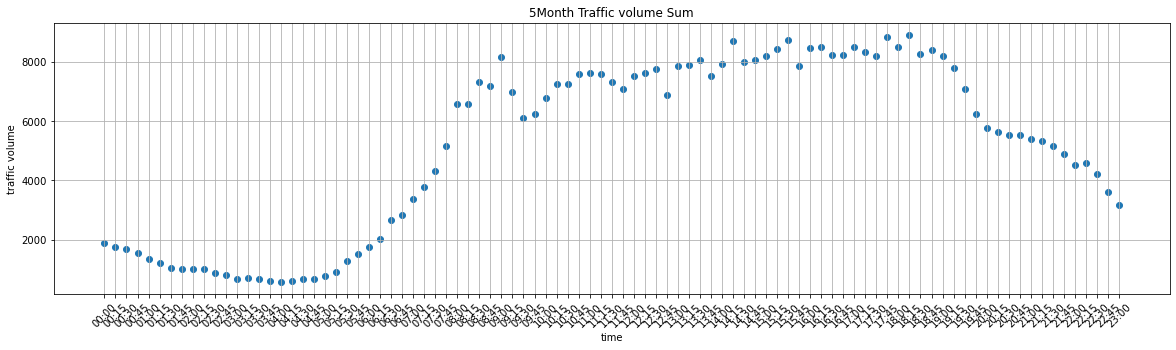

In [15]:
# 특정월 교통량 합계 그래프
ChartPlot((20,5),month_sum,1,0,'5') # figsize,df,plotType : 0 = 선 1 = 점, SumOrStat : 0 = Sum 1 = Average, 월

# 한곳에 그래프 여러개 그리기
# fig,ax=plt.subplots(nrows=2,ncols=2)
# ax[0,0].plot(X,Y1)
# ax[1,0].plot(X,Y2)
# ax[1,1].plot(X,Y3)
# ax.plot(X,Y1)

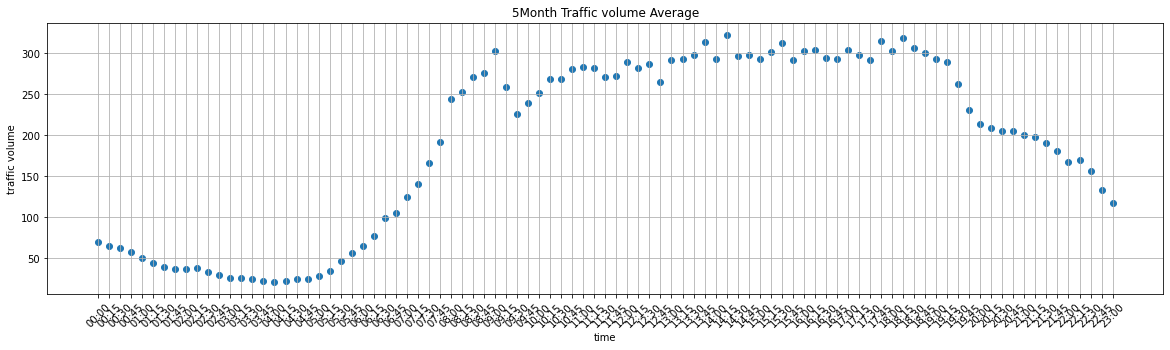

In [16]:
# 특정월 교통량 평균 그래프
ChartPlot((20,5),month_stat,1,1,'5') # figsize,df,plotType : 0 = 선 1 = 점, SumOrStat : 0 = Sum 1 = Average, 월

In [17]:
# 4~8월 내덕 칠거리 평균 교통량 그래프 출력
whole_sum = total_df.copy()
whole_stat = total_df.copy()
whole_sum = Separation_Date_Time(whole_sum)
whole_sum = Extraction_DF_Traffic_SumOrStat(whole_sum,0)
whole_stat = Separation_Date_Time(whole_stat)
whole_stat = Extraction_DF_Traffic_SumOrStat(whole_stat,1)

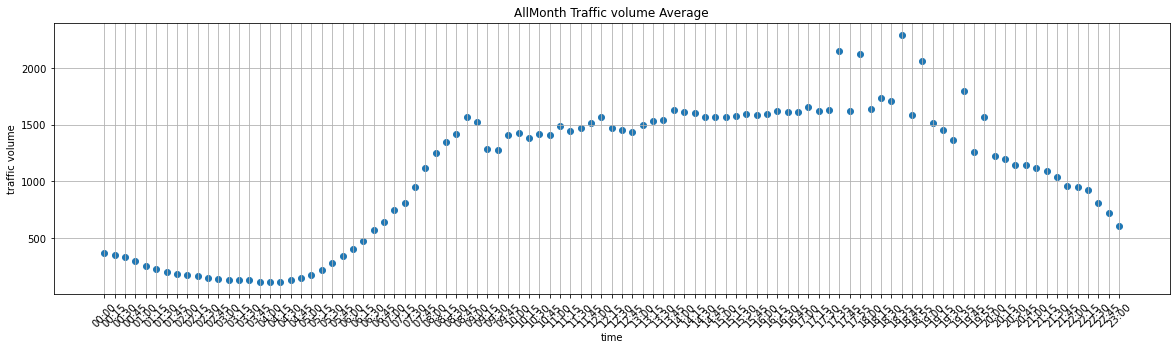

In [18]:
# 4~8월 내덕 칠거리 교통량 합계 그래프 출력
ChartPlot((20,5),whole_stat,1,1,'All') # figsize,df,plotType : 0 = 선 1 = 점, SumOrStat : 0 = Sum 1 = Average, 월

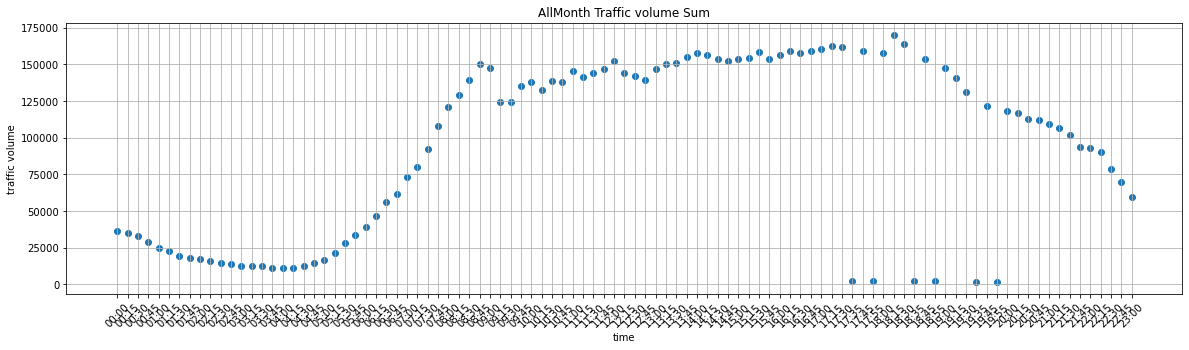

In [19]:
# 4~8월 내덕 칠거리 교통량 평균 그래프 출력
ChartPlot((20,5),whole_sum,1,0,'All') # figsize,df,plotType : 0 = 선 1 = 점, SumOrStat : 0 = Sum 1 = Average, 월

In [20]:
# 상관 분석 전에 shape 맞게 필요
whole_stat = Preprocessing_IsNull(whole_stat,month_stat)
Correlation_df = MakeCorrelation_df('time',
                                    'month_Traffic',
                                    'whole_Traffic',
                                    month_stat['교통량'].index, 
                                    month_stat.values.reshape(93,),
                                    whole_stat.values.reshape(93,))
Correlation_df

,time,month_Traffic,whole_Traffic
0,00:00,69.22,373.30
1,00:15,64.81,355.00
2,00:30,62.44,333.57
3,00:45,57.59,297.05
4,01:00,50.33,257.49
...,...,...,...
88,22:00,167.85,950.84
89,22:15,169.63,923.92
90,22:30,156.56,810.12
91,22:45,133.67,719.98


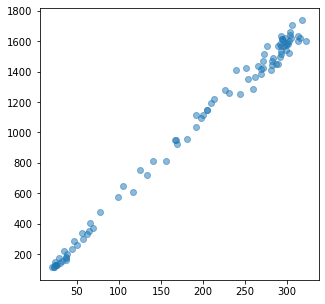

In [21]:
# 상관관계 그래프
# X  : 월별 평균 교통량, Y : 전체월별 평균 교통량
DrawCorrelation(Correlation_df.month_Traffic.values,Correlation_df.whole_Traffic.values,(5,5))

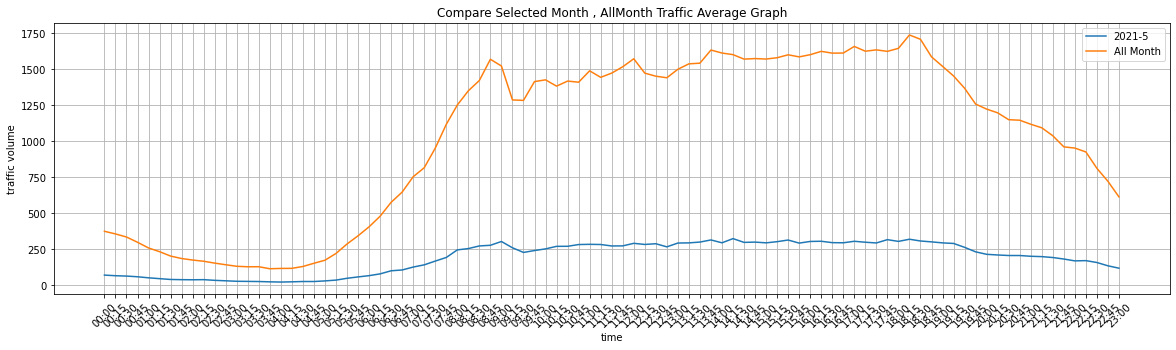

In [22]:
# 해당 월과 전체 월 평균 교통량 비교 그래프
# 이격도 차이
sample_df = total_df.copy()
Compare_OneMonth_AllMonth_TrafficAverage(2021,5,sample_df)

In [23]:
Correlation_df.corr(method = 'pearson')

,month_Traffic,whole_Traffic
month_Traffic,1.000000,0.996273
whole_Traffic,0.996273,1.000000


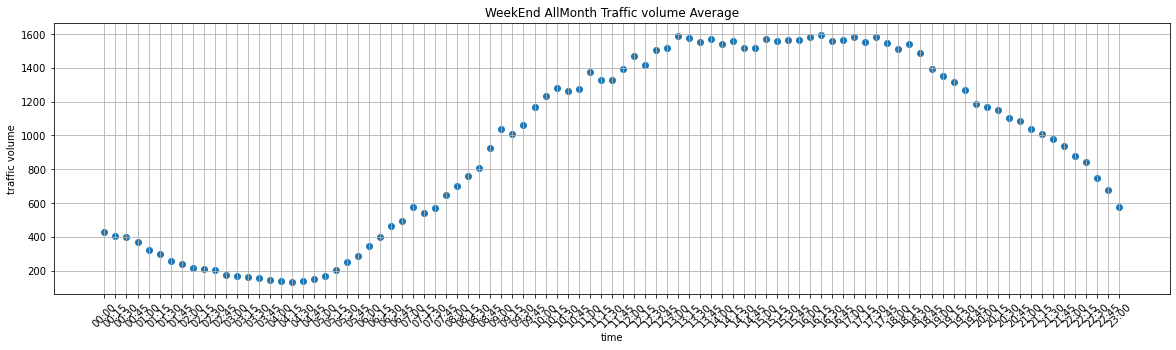

In [24]:
# 전체 달 중에서 주말 데이터 추출
AllMonthWeekEnd = Extraction_SelectedAllMonth_WeekEndData(total_df).copy()
AllMonthWeekEnd = Separation_Date_Time(AllMonthWeekEnd)
AllMonthWeekEnd = Extraction_DF_Traffic_SumOrStat(AllMonthWeekEnd,1)
ChartPlot((20,5),AllMonthWeekEnd,1,1,'WeekEnd All')

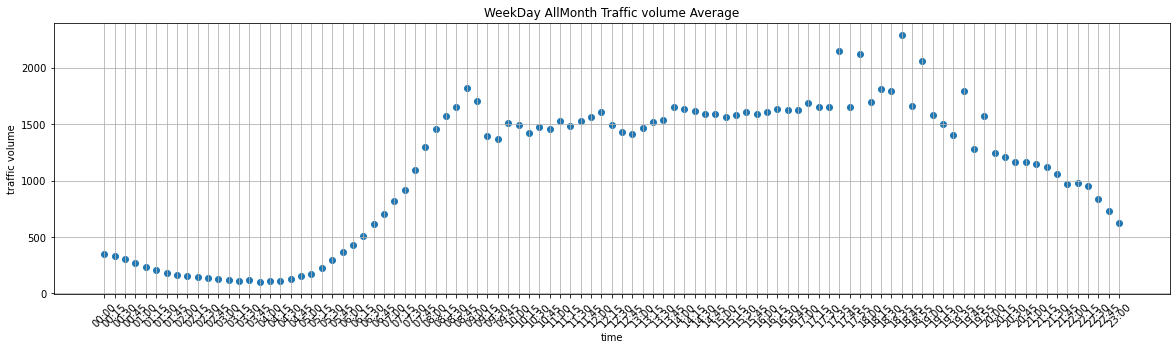

In [25]:
# 전체 달 중에서 평일 데이터 추출
AllMonthWeekDay = Extraction_SelectedAllMonth_WeekDayData(total_df).copy()
AllMonthWeekDay = Separation_Date_Time(AllMonthWeekDay)
AllMonthWeekDay = Extraction_DF_Traffic_SumOrStat(AllMonthWeekDay,1)
ChartPlot((20,5),AllMonthWeekDay,1,1,'WeekDay All')

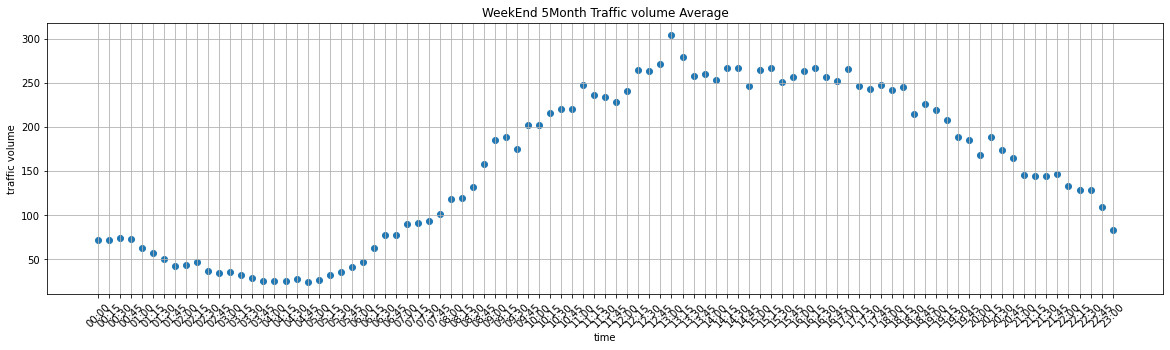

In [26]:
# 특정 달 중에서 주말 데이터 추출
OneMonth_weekend = Extraction_SelectedMonth_WeekEndData(2021,5,total_df).copy()
OneMonth_weekend = Separation_Date_Time(OneMonth_weekend)
OneMonth_weekend = Extraction_DF_Traffic_SumOrStat(OneMonth_weekend,1)
ChartPlot((20,5),OneMonth_weekend,1,1,'WeekEnd 5')

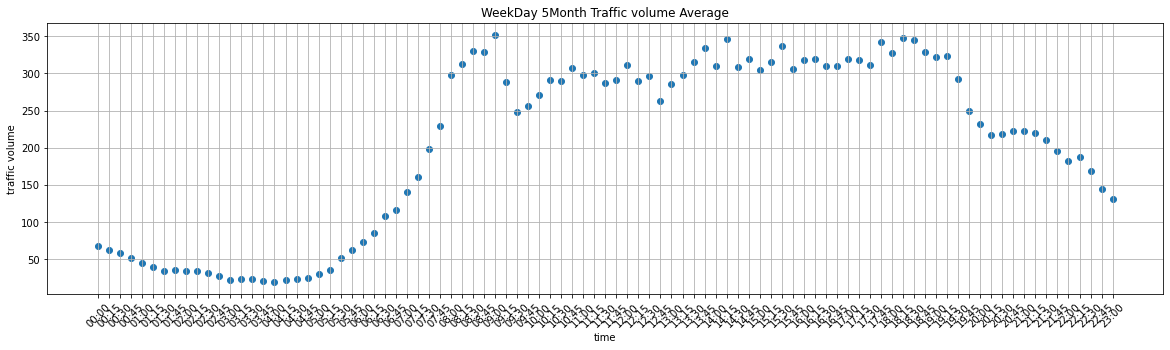

In [27]:
# 특정 달 중에서 평일 데이터 추출
OneMonth_weekday = Extraction_SelectedMonth_WeekDayData(2021,5,total_df).copy()
OneMonth_weekday = Separation_Date_Time(OneMonth_weekday)
OneMonth_weekday = Extraction_DF_Traffic_SumOrStat(OneMonth_weekday,1)
ChartPlot((20,5),OneMonth_weekday,1,1,'WeekDay 5')

In [28]:
# 상관분석을 위한 shape 확인
print(AllMonthWeekDay.values.shape)
print(AllMonthWeekEnd.values.shape)

(99, 1)
(93, 1)


In [29]:
AllMonthWeekDay = Preprocessing_IsNull(AllMonthWeekDay,AllMonthWeekEnd)

In [30]:
AllMonthWeek_df=MakeCorrelation_df('time',
                           'AllMonthWeekday',
                           'AllMonthWeekend',
                            AllMonthWeekDay.index,
                           AllMonthWeekDay.values.reshape(93,),
                           AllMonthWeekEnd.values.reshape(93,))
AllMonthWeek_df

,time,AllMonthWeekday,AllMonthWeekend
0,00:00,353.41,425.59
1,00:15,335.38,406.59
2,00:30,308.11,400.52
3,00:45,269.34,369.93
4,01:00,232.09,323.37
...,...,...,...
88,22:00,979.04,876.67
89,22:15,955.35,841.26
90,22:30,833.73,745.65
91,22:45,735.13,678.62


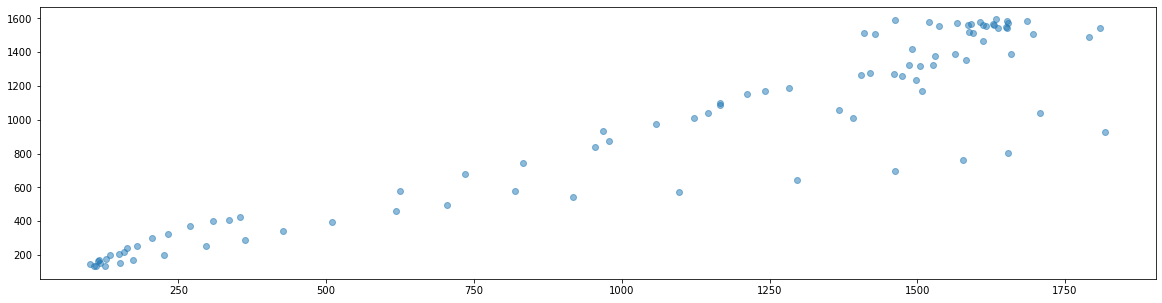

In [31]:
# 평일, 주말 교통량 평균 상관관계 그래프
DrawCorrelation(AllMonthWeekDay.values,AllMonthWeekEnd.values,(20,5))

In [32]:
AllMonthWeek_df.corr(method = 'pearson')

,AllMonthWeekday,AllMonthWeekend
AllMonthWeekday,1.000000,0.935858
AllMonthWeekend,0.935858,1.000000


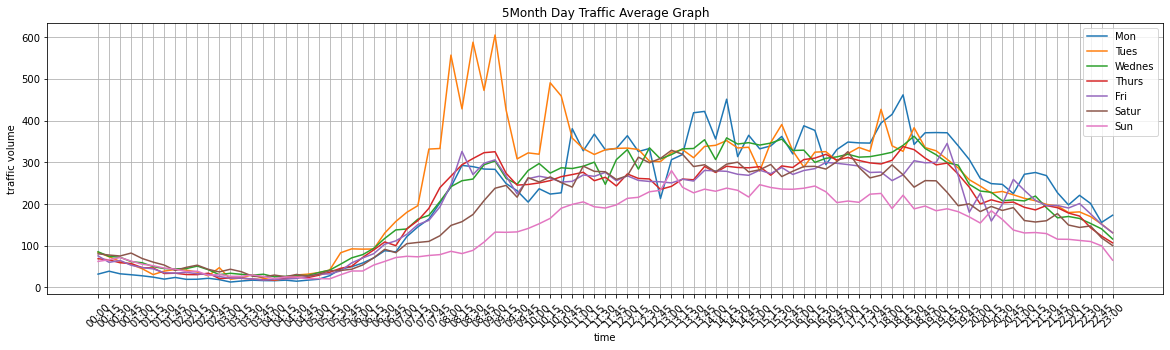

In [33]:
# 월별 요일별 교통량 평균 그래프
All_df = total_df.copy()
DrawMonthlyDayGraph(2021,5,All_df,(20,5))

In [34]:
# 월별 요일별 교통량 평균 그래프 (국경일 제외)
All_df = total_df.copy()
All_df = Separation_Date_Time(All_df)
NationalHolidayWeekDayDf = getHolidayWeekDay(NationalHolidayDf).copy()

NationalHolidayWeekDayDf['날짜'] = NationalHolidayWeekDayDf['날짜'].dt.strftime('%Y-%m-%d') 
All_df['날짜'] = All_df['날짜'].dt.strftime('%Y-%m-%d')

for _date in NationalHolidayWeekDayDf['날짜']:
    _arr = All_df[All_df['날짜']==_date].index
    if(len(_arr) != 0):
        All_df = All_df.drop(_arr)

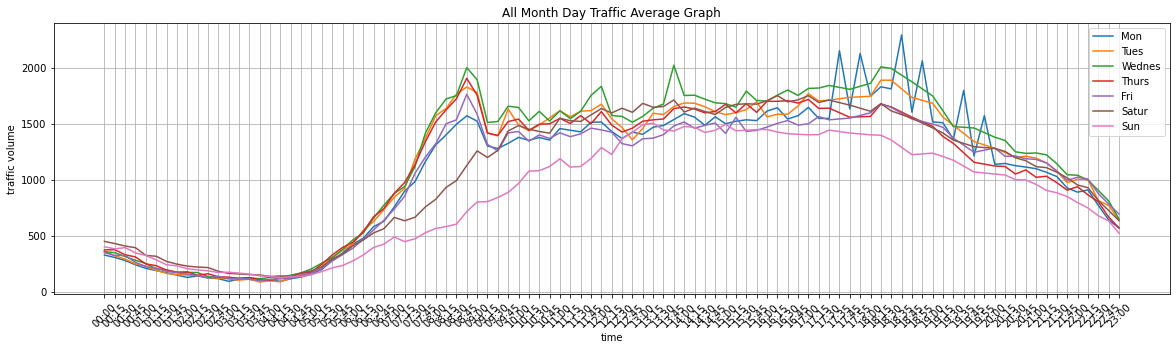

In [35]:
# 전체월별 요일별 교통량 평균 그래프
AllMonth_df = total_df.copy()
DrawAllMonthDayGraph(2021,AllMonth_df,(20,5))

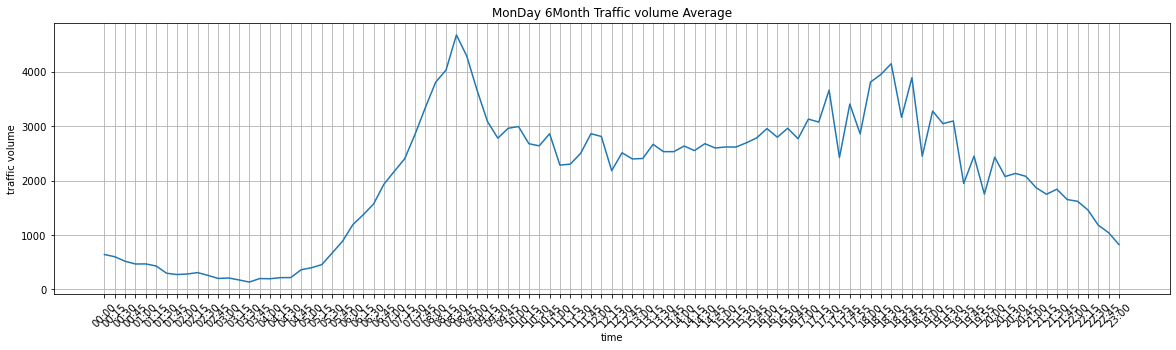

In [36]:
# 월별 특정 요일 교통량 평균 그래프
Monthly_OneDay_AverageDF = Extraction_Monthly_SelectedDayData(2021,6,0,'./내덕칠거리/').copy()
Monthly_OneDay_AverageDF = Separation_Date_Time(Monthly_OneDay_AverageDF)
Monthly_OneDay_AverageDF = Extraction_DF_Traffic_SumOrStat(Monthly_OneDay_AverageDF,1)
ChartPlot((20,5),Monthly_OneDay_AverageDF,0,1,'MonDay 6')

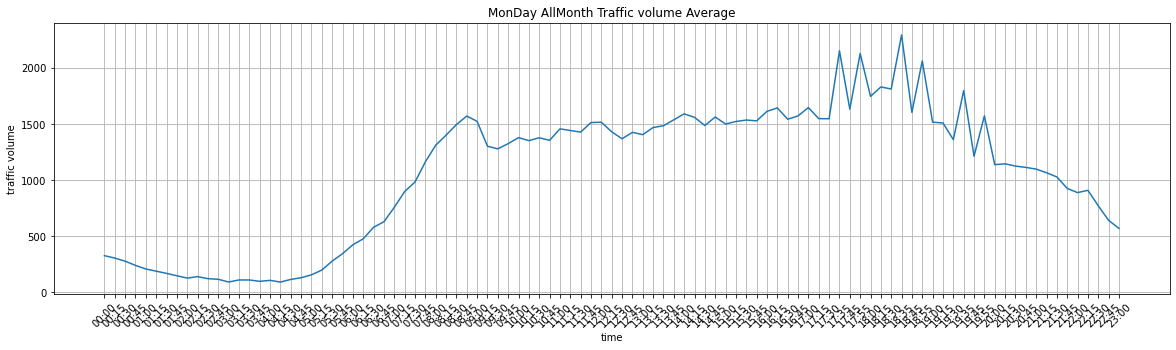

In [37]:
#전체 월 중에서 특정 요일 교통량 평균 그래프
AllMonthly_OneDay_AverageDF = Extraction_AllMonthly_SelectedDayData(0,total_df).copy()
AllMonthly_OneDay_AverageDF = Separation_Date_Time(AllMonthly_OneDay_AverageDF)
AllMonthly_OneDay_AverageDF = Extraction_DF_Traffic_SumOrStat(AllMonthly_OneDay_AverageDF,1)
ChartPlot((20,5),AllMonthly_OneDay_AverageDF,0,1,'MonDay All')

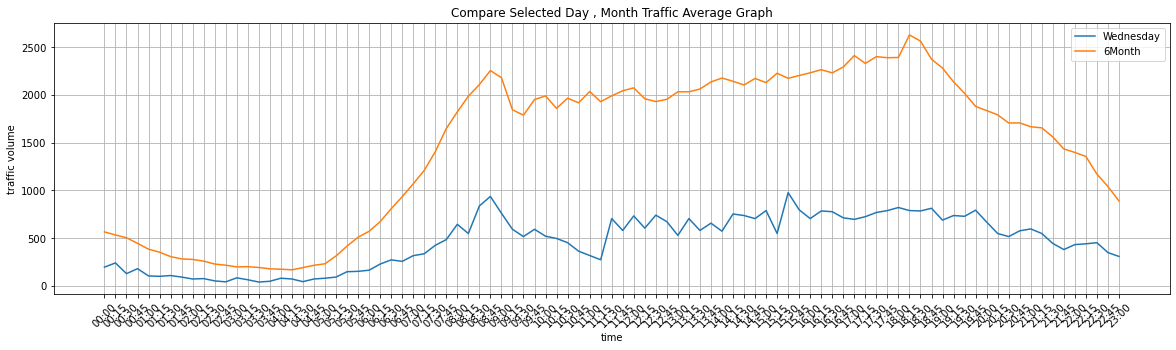

In [38]:
All_df = total_df.copy()
Compare_OneDay_Month_TrafficAverage(2021,6,2,All_df)

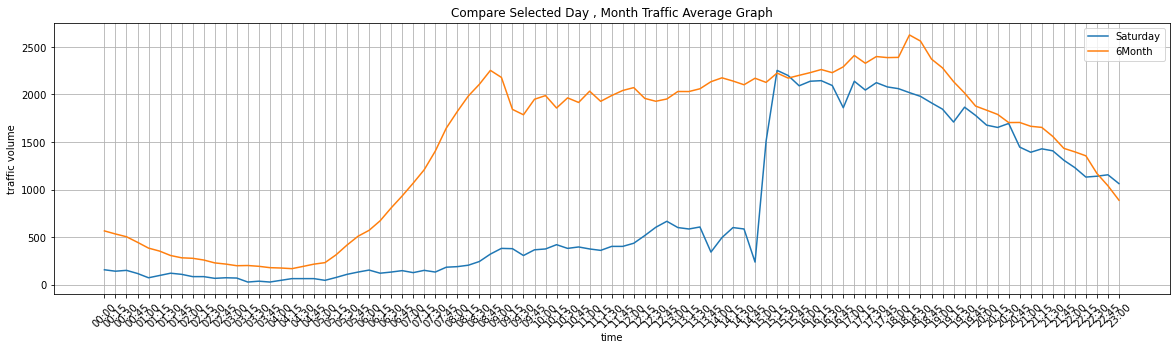

In [39]:
All_df = total_df.copy()
Compare_OneDay_Month_TrafficAverage(2021,6,5,All_df)

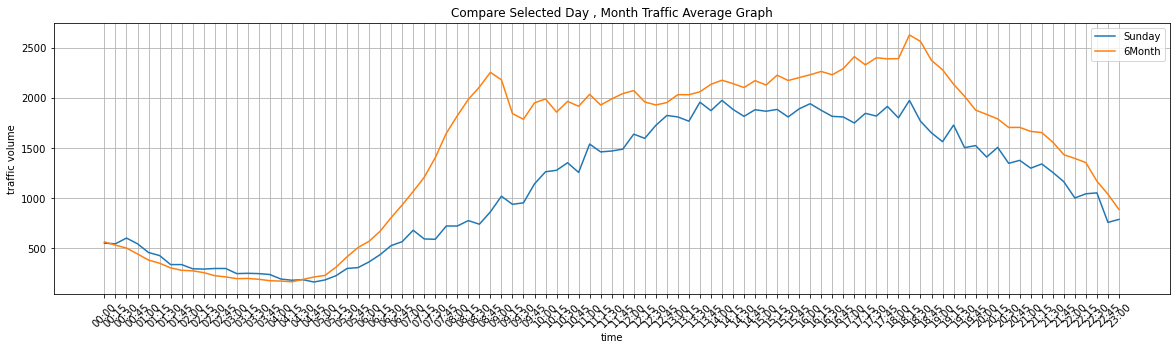

In [40]:
All_df = total_df.copy()
Compare_OneDay_Month_TrafficAverage(2021,6,6,All_df)

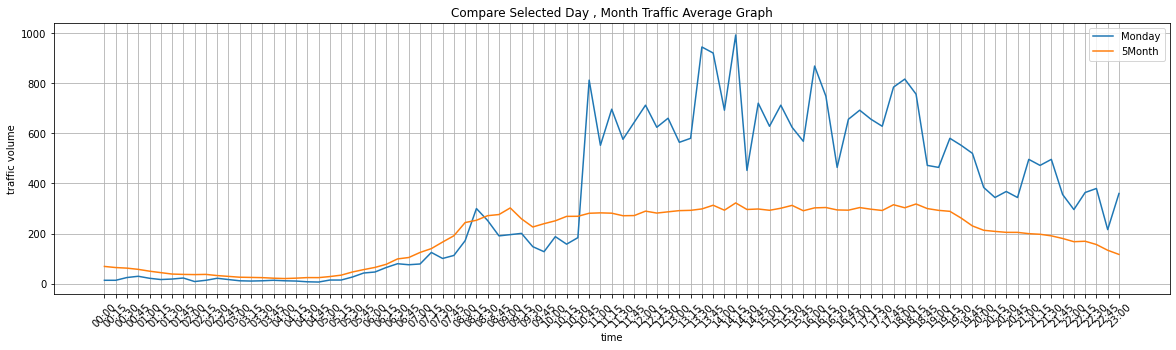

In [41]:
All_df = total_df.copy()
Compare_OneDay_Month_TrafficAverage(2021,5,31,All_df)

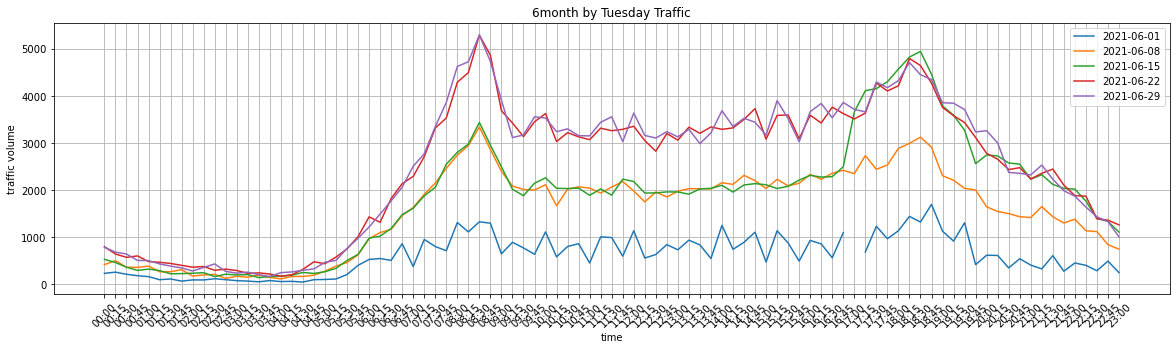

In [42]:
# 특정월에서 매주 요일(0~6 : 월~일) 그래프 출력 , 결측치는 경우의 수가 많아 필요 그래프 그릴 시 
# Extraction_SelectedMonth_SelectedDaysData()로 df 반환해서 결측치 경우의 수에 따라 전처리
Draw_SelectedMonth_SelectedDays_Traffic(2021,6,1,'./내덕칠거리/',(20,5))

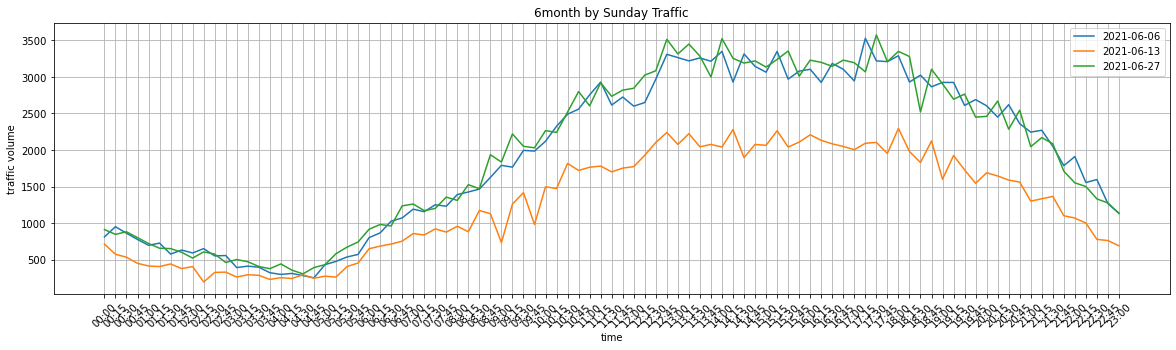

In [43]:
Draw_SelectedMonth_SelectedDays_Traffic(2021,6,6,'./내덕칠거리/',(20,5))